In [1]:
from fore_utils import *

In [78]:
import torch
import torch.nn as nn
    
class TransformerModel(nn.Module):
    def __init__(self, window_size: int = 24, variables: int = 6, d_model=64, nhead=4, num_layers=2, output_dim: int = 12):
        super(TransformerModel, self).__init__()

        input_dim = window_size * variables

        self.encoder = nn.Linear(input_dim, d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.encoder(x)

        x = x.unsqueeze(1) 
        
        x = self.transformer_encoder(x)

        x = self.decoder(x.squeeze(1))
        return x


In [79]:
window_size = 48
steps = 24
spaces = 0
hidden_size = 64
batch_size = 32

config = {
    "hidden_layer_sizes": [hidden_size],
    "window_size" : [window_size],
    "step_size" : [steps],
    "spaces" : [spaces],
    "batch_size": [batch_size]
}

# Hyperparameters
n_epochs = 10
warmup_epochs = 1
initial_lr = 1e-4
early_stopping_patience = 5
checkpoint_path = 'best_model.pth'

wandb.init(project="time_series_forecasting", name="transfromer", config=config)

model = TransformerModel(window_size=window_size, 
                         d_model=hidden_size, 
                         nhead=4, 
                         num_layers=2, 
                         output_dim=steps)

train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, verbose=True)
train_loader = DataLoader(train_set,
                           batch_size=batch_size, shuffle=True)
    
val_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, verbose=True)
val_loader = DataLoader(val_set,
                           batch_size=batch_size, shuffle=False)

train_model(model, train_loader, val_loader, config, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path)



Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Features shape: torch.Size([35064, 6])
Targets shape: torch.Size([35064])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Details for val set:
Data from ['2022'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Epoch 0, Batch 0, Loss: 2.7051
Epoch 0, Batch 100, Loss: 0.3477
Epoch 0, Batch 200, Loss: 0.3552
Epoch 0, Batch 300, Loss: 0.3410
Epoch 0, Batch 400, Loss: 0.3290
Epoch 0, Batch 500, Loss: 0.4750
Epoch 0, Batch 600, Loss: 0.2885
Epoch 0, Batch 700, Loss: 0.4694
Epoch 0, Batch 800, Loss: 0.4405
Epoch 0, Batch 900, Loss: 0.3075
Epoch 0, Batch 1000, Loss: 0.1955
Epoch 0 Completed, Average Training Loss: 0.3745
Validation Loss after Epoch 0: 0.3230
Learning rate after Epoch 0: 0.000100
New best model saved with validation loss: 0.3230
Epoch 1, Batch 0, Loss: 0.3608
Epoch 1, Batch 100, Loss: 0.2750
Epoch 1, Batc

KeyboardInterrupt: 

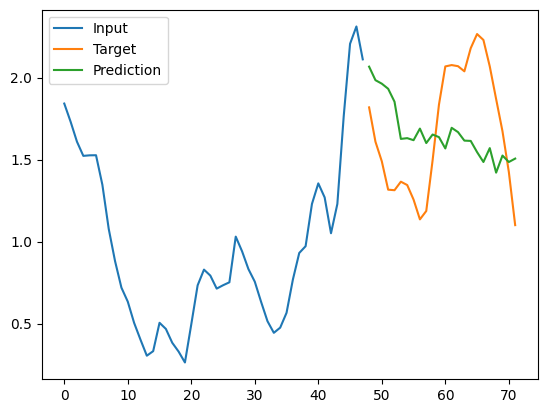

In [86]:
for batch in train_loader:
    x, y = batch
    break

y_pred = model(x.float())

plt.plot(np.arange(window_size), x[0, :, 5].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()
